# COMP579 Assignment 3

Group 67
- Sienna Hsu (260948832)
- Ronald Truong (260427874)

Version 5
- reorganized notebook sections
- save/load pickle files keeps track of which algos and hypers are in the *-returns.npy pickle file
- but not feature_basis_method, num_tilings, num_tiles, tile_coding_method, which we already decided

Fixed
- fix the bug in version 5, pickle wasn't manually adjusted for policy methods


In [ ]:
!pip install gymnasium==0.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
# import pickle
# from google.colab import drive

np.random.seed(579)
print("Gym version:", gym.__version__)

Gym version: 0.28.1


In [ ]:
# Sienna
# drive.mount('/content/gdrive')

# This should work on any system
import os
print(f"current working directory: {os.getcwd()}")
DIRECTORY_NAME = "comp-579-a3-data"
# create a new directory if it doesn't exist
if not os.path.exists(DIRECTORY_NAME):
    os.makedirs(DIRECTORY_NAME)
    DIRECTORY_PATH = os.path.abspath(DIRECTORY_NAME)
    print(f"created directory: {DIRECTORY_PATH}")
else:
    DIRECTORY_PATH = os.path.abspath(DIRECTORY_NAME)
    print(f"directory already exists: {DIRECTORY_PATH}")

current working directory: /content
created directory: /content/comp-579-a3-data


## Environment functions


In [ ]:
"""
Feature Non-Linear Basis Transformation Functions
"""

identity = lambda s: s

def cartpole_transform(s):
    """
    using domain knowledge to extract features from state
    accounting for interaction between features
    """
    extra_features = np.array([np.abs(s[0] * s[2]), np.abs(s[2] * s[3])]) # position*angle, angle*angular_velocity
    s = np.concatenate([s, extra_features])
    return s

def update_low_high(feature_basis_func, low, high):
    """
    update low and high to account for the new feature space
    """
    low_transformed = feature_basis_func(low)
    high_transformed = feature_basis_func(high)
    low = np.minimum(low_transformed, high_transformed)
    high = np.maximum(low_transformed, high_transformed)
    return low, high

"""
Tile Coding Functions
"""

def make_tilings(num_tilings, num_tiles, low, high):
    """
    num_tilings, num_tiles, low and high should be lists of length equal state_dim
    The tiles are EVENLY spaced (assuming state distribution is uniform between low and high)
    The tilings are UNIFORMALLY offset and "CENTERED" between low and high.
    Returns a list of state_dim lists of num_tilings lists of (num_tiles - 1) split points.
    """
    # convert to numpy array
    num_tilings = np.array(num_tilings)
    num_tiles = np.array(num_tiles)
    low = np.array(low)
    high = np.array(high)

    # calculate dimension-specific values
    state_dim = len(low)
    ranges = high - low
    tile_width = ranges / num_tiles # for each dimension, evenly spaced tiles
    offset = tile_width / num_tilings # for each dimension,uniformally offset tilings
    # for each dimension, centering the intervals
    initial_first_split_point = low + (ranges - (num_tilings - 1) * offset - (num_tiles - 2) * tile_width) / 2
    initial_last_split_point = initial_first_split_point + (num_tiles - 2) * tile_width

    tilings = []
    for i in range(state_dim):
        partitions = [] # 1D tiling
        for j in range(num_tilings[i]):
            first_split_point = initial_first_split_point[i] + j * offset[i]
            last_split_point = initial_last_split_point[i] + j * offset[i]
            split_points = np.linspace(first_split_point, last_split_point, num_tiles[i] - 1)
            partitions.append(split_points)
        tilings.append(partitions)

    return tilings

def tile_code(state_features, tilings, d, independent_features=True):
    """
    state_features and tilings must be the same length
    state_features: raw state features
    Returns a d-dimension vector of active features
    """
    tile_coded_features = np.zeros(d)

    if independent_features:
        index = 0
        for i, raw_feature in enumerate(state_features):
            for tiling in tilings[i]:
                bin_index = np.digitize(raw_feature, tiling)
                tile_coded_features[index + bin_index] = 1
                index += (len(tiling) + 1)
    else:
        # textbook implementation
        raise("Not implemented yet")

    return tile_coded_features

## Value-based Algorithm classes

Here we use on-policy learning with ϵ-greedy policy.

In [ ]:
class ExpectedSarsa:
  def __init__(self, env, d, alpha, epsilon, epsilon_dr, gamma):
    self.env = env
    self.alpha = alpha
    self.epsilon = epsilon
    self.epsilon_dr = epsilon_dr
    self.gamma = gamma
    self.theta = np.random.uniform(low=-0.001, high=0.001, size=(env.action_space.n, d))


  def select_action(self, x):
    """
    x is the d-dimensional feature vector of a state
    """
    # calculate the estimated action values
    action_values = [np.dot(self.theta[a], x) for a in range(self.env.action_space.n)]

    # get greedy action with random tie-breaking
    max_value = np.max(action_values)
    indices_of_max_vals = np.ravel(np.where(action_values == max_value))

    # numpy has numerical issues when using np.where when values are too small
    # and will return an empty list
    if len(indices_of_max_vals) == 0:
      # simply choose the first max value
      greedy_action = np.argmax(action_values)
    else:
      greedy_action = np.random.choice(indices_of_max_vals)

    # get random action
    random_action = self.env.action_space.sample()

    # epsilon greedy
    return np.random.choice([greedy_action, random_action], p=[1-self.epsilon, self.epsilon])


  def update(self, x, a, r, x_prime, a_prime):

    # calculate the probability of selecting each action according to epsilon-greedy
    action_values = [np.dot(self.theta[a], x_prime) for a in range(self.env.action_space.n)]
    max_value = np.max(action_values)
    indices_of_max_vals = np.ravel(np.where(action_values == max_value))

    # This is to check the same numerical issue mentioned above
    if len(indices_of_max_vals) == 0:
      indices_of_max_vals = [np.argmax(action_values)]

    num_of_max_vals = len(indices_of_max_vals)
    probs = [((1-self.epsilon) / num_of_max_vals + self.epsilon / self.env.action_space.n) \
             if a in indices_of_max_vals else (self.epsilon / self.env.action_space.n) \
             for a in range(self.env.action_space.n)]

    # calculate the expected term in the target
    expected_term = 0
    for action in range(self.env.action_space.n):
      expected_term += probs[action] * action_values[action]

    # update theta
    target = r + self.gamma * expected_term
    self.theta[a] += self.alpha * (target - np.dot(self.theta[a], x)) * np.array(x)

    # decay the epsilon
    self.epsilon *= self.epsilon_dr


class Q_learning:
  def __init__(self, env, d, alpha, epsilon, epsilon_dr, gamma):
    self.env = env
    self.alpha = alpha
    self.epsilon = epsilon
    self.epsilon_dr = epsilon_dr
    self.gamma = gamma
    self.theta = np.random.uniform(low=-0.001, high=0.001, size=(env.action_space.n, d))


  def select_action(self, x):
    """
    x is the d-dimensional feature vector of a state
    """
    # calculate the estimated action values
    action_values = [np.dot(self.theta[a], x) for a in range(self.env.action_space.n)]

    # get greedy action with random tie-breaking
    max_value = np.max(action_values)
    indices_of_max_vals = np.ravel(np.where(action_values == max_value))

    # numpy has numerical issues when using np.where when values are too small
    # and will return an empty list
    if len(indices_of_max_vals) == 0:
      # simply choose the first max value
      greedy_action = np.argmax(action_values)
    else:
      greedy_action = np.random.choice(indices_of_max_vals)

    # get random action
    random_action = self.env.action_space.sample()

    # epsilon greedy
    return np.random.choice([greedy_action, random_action], p=[1-self.epsilon, self.epsilon])


  def update(self, x, a, r, x_prime, a_prime):
    # update theta
    action_values_x_prime = [np.dot(self.theta[a], x_prime) for a in range(self.env.action_space.n)]
    target = r + self.gamma * np.max(action_values_x_prime)
    self.theta[a] += self.alpha * (target - np.dot(self.theta[a], x)) * np.array(x)

    # decay the epsilon
    self.epsilon *= self.epsilon_dr

## Value-based Helper functions

In [ ]:
# function that runs each episode for value-based algorithms
def run_episode_val_based(algo, feature_basis_func, tile_func, ep_num):

  total_r = 0

  # initialize s and a
  s, info = algo.env.reset()
  s = feature_basis_func(s)
  x = tile_func(s)
  a = algo.select_action(x)
  terminated = False
  truncated = False

  while not (terminated or truncated):
    # take action a and observe r and s_prime
    s_prime, r, terminated, truncated, info = algo.env.step(a)
    x_prime = tile_func(s_prime)
    total_r = r + algo.gamma * total_r

    # choose a_prime from x_prime using epsilon-greedy policy
    a_prime = algo.select_action(x_prime)

    # update theta
    algo.update(x, a, r, x_prime, a_prime)

    # update x and a
    x = x_prime
    a = a_prime

  return total_r, terminated, truncated


# function that runs each hyperparameter setting
def run_hyperparams_val_based(env, feature_basis_func, tile_func, d, algo, alpha, epsilon, epsilon_dr, gamma, trial_num, ep_num, verbose):
  """
  Global dependencies just for verbose:
  - num_tilings
  - num_tiles
  """

  # arrays to keep track of rewards, dimension is trial_num x ep_num
  rewards = []

  for trial_i in range(trial_num):

    cur_algo = algo(env, d, alpha, epsilon, epsilon_dr, gamma)  # each trial is independent
    trial_r = []

    for ep_i in range(ep_num):
      ep_r, terminated, truncated = run_episode_val_based(cur_algo, feature_basis_func, tile_func, ep_i)
      trial_r.append(ep_r)

      if verbose:
        print(f'{env.unwrapped.spec.id} {str(num_tilings).replace(" ", "")} {str(num_tiles).replace(" ", "")} {algo.__name__} (a={alpha} e={round(cur_algo.epsilon, 4)}) (trial {trial_i} ep {ep_i}) {"terminated" if terminated else "truncated"} {ep_r}')

    rewards.append(trial_r)

  return rewards


# function that runs the experiments for an environment
def run_env_val_based(env_name, feature_basis_func, tile_func, d, algos, alphas, epsilons, epsilon_dr, gamma, trial_num, ep_num, verbose=False):
  # rewards of all algorithms and hyperparameter settings
  # dimension is len(algos) x len(alphas) x len(epsilons) x trial_num x ep_num
  rewards = []

  # enviroment can be reused across different algorithms
  env = gym.make(env_name)

  for algo in algos:
    algo_r = []

    for alpha in alphas:
      alpha_r = []

      for epsilon in epsilons:
        alpha_r.append(run_hyperparams_val_based(env, feature_basis_func, tile_func, d, algo, alpha, epsilon, epsilon_dr, gamma, trial_num, ep_num, verbose))
        if verbose: print()

      algo_r.append(alpha_r)

      if verbose: print()

    rewards.append(algo_r)

    if verbose: print()

  return rewards


# function to check the dimension of nested list
def nested_list_dimensions(lst):
    if not isinstance(lst, list):
        return ()  # Return an empty tuple if the input is not a list

    dimensions = [len(lst)]  # Get the length of the current list
    if lst:  # Check if the current list is not empty
        dimensions.extend(nested_list_dimensions(lst[0]))  # Recursively get dimensions of the first element

    return tuple(dimensions)


# function that plots the rewards
def plot_learning_val_based(env_name, rewards):
  """
  Global dependencies:
  - list: algos
  - list: alphas
  - list: epsilons
  - int: trial_n
  - int: ep_n

  Design by contract:
  - rewards needs to be dimension: ( len(algos) x len(alphas) x len(epsilons) x trial_n x ep_n )
  """
  plt.style.use('seaborn-v0_8')
  cm = plt.get_cmap('tab10')
  NUM_COLORS = 9

  for algo_i, algo in enumerate(algos):

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for alpha_i, alpha in enumerate(alphas):

      for epsilon_i, epsilon in enumerate(epsilons):

        rewards_over_trials = []   # an array of trial_n x ep_n

        for trial_i in range(trial_n):
          rewards_over_episodes = []

          for ep_i in range(ep_n):
            rewards_over_episodes.append(rewards[algo_i][alpha_i][epsilon_i][trial_i][ep_i])

          rewards_over_trials.append(rewards_over_episodes)

        rewards_over_trials = np.asarray(rewards_over_trials)
        mean_rewards_over_trials = np.mean(rewards_over_trials, axis=0)
        third_quantile_over_trials = np.quantile(rewards_over_trials, 0.75, axis=0)
        first_quantile_over_trials = np.quantile(rewards_over_trials, 0.25, axis=0)

        label = f'\u03B1 = {alpha}, \u03B5 = {epsilon}'
        ax.plot(mean_rewards_over_trials, label = label)
        ax.fill_between(range(ep_n), third_quantile_over_trials, first_quantile_over_trials, alpha=0.3)

    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel("Episode", fontsize=14)
    ax.set_ylabel("Return", fontsize=14)
    ax.set_title(f"{env_name}, {algo.__name__} return over episodes", fontsize=18)
    plt.show()

## Policy-based Algorithm classes

In [ ]:
# numerically stable version
def softmax(z, temp):
  """z is a list of values"""
  max_z = np.max(z)
  exp_vals = np.exp((z - max_z) / temp)
  return exp_vals / np.sum(exp_vals)


# function to replace the large and small values of an array with the specified
# max and min values
def fix_overflow_and_underflow(arr, max_val, min_val):
  for i in range(len(arr)):
    if arr[i] > max_val or np.isposinf(arr[i]):
      arr[i] = max_val
    elif arr[i] < min_val or np.isneginf(arr[i]):
      arr[i] = min_val


class Reinforce:
  def __init__(self, env, d, alpha, alpha_w, gamma, temp, temp_decay_rate):
    """alpha_w is a place holder to make Reinforce compatible with Actor Critic"""
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.temp_decay_rate = temp_decay_rate
    self.theta = np.random.uniform(low=-0.001, high=0.001, size=(env.action_space.n, d))


  def select_action(self, x):
    """
    x is the d-dimensional feature vector of a state
    """
    # calculate the probability of selecting each action with softmax
    z = [np.dot(self.theta[a], x) for a in range(self.env.action_space.n)]
    action_probs = softmax(z, self.temp)

    # select an action based on action_probs
    return np.random.choice(self.env.action_space.n, p=action_probs)


  def update(self, x, a, t, G):
    # update theta
    self.theta[a] += self.alpha * (self.gamma ** t) * G * np.array(x) / self.temp

    # decay the temperature
    # temperature has to be larger than 0.
    # Here we limit the smallest temperature to be 0.00000001 (kind of arbitrary)
    # if self.temp * self.temp_decay_rate > 0.00000001:
    self.temp *= self.temp_decay_rate


class ReinforceBaseline:
  def __init__(self, env, d, alpha_theta, alpha_w, gamma, temp, temp_decay_rate):
    """alpha_w is a place holder to make Reinforce compatible with Actor Critic"""
    self.env = env
    self.alpha_theta = alpha_theta
    self.alpha_w = alpha_w
    self.gamma = gamma
    self.temp = temp
    self.temp_decay_rate = temp_decay_rate
    self.theta = np.random.uniform(low=-0.001, high=0.001, size=(env.action_space.n, d))
    self.w = np.random.uniform(low=-0.001, high=0.001, size=(d))


  def select_action(self, x):
    """
    x is the d-dimensional feature vector of a state
    """
    # calculate the probability of selecting each action with softmax
    z = [np.dot(self.theta[a], x) for a in range(self.env.action_space.n)]
    action_probs = softmax(z, self.temp)

    # select an action based on action_probs
    return np.random.choice(self.env.action_space.n, p=action_probs)


  def update(self, x, a, t, G):
    # update theta
    delta = G - np.dot(self.w, x)
    self.w += self.alpha_w * delta * np.array(x)
    self.theta[a] += self.alpha_theta * (self.gamma ** t) * delta * np.array(x) / self.temp

    # decay the temperature
    self.temp *= self.temp_decay_rate


class ActorCritic:
  def __init__(self, env, d, alpha_theta, alpha_w, gamma, temp, temp_decay_rate):
    self.env = env
    self.alpha_theta = alpha_theta
    self.alpha_w = alpha_w
    self.gamma = gamma
    self.temp = temp
    self.temp_decay_rate = temp_decay_rate
    self.theta = np.random.uniform(low=-0.001, high=0.001, size=(env.action_space.n, d))
    self.w = np.random.uniform(low=-0.001, high=0.001, size=(d))


  def select_action(self, x):
    """
    x is the d-dimensional feature vector of a state
    """
    # calculate the probability of selecting each action with softmax
    # print("theta: ", self.theta)
    z = [np.dot(self.theta[a], x) for a in range(self.env.action_space.n)]

    # for Actor-Critic specifically, z could go to infinity as the training goes on
    # we replace the large values with the a less large value that wouldn't cause
    # numerical overflow when we perform (z - max_z) / temp
    # the largest value for float-64 is around 1e+308
    # the temp lowest threshold we set is 1e-8
    # so we choose 1e+300 as the max value for z
    #fix_overflow_and_underflow(z, 1e+300, -1e+300)

    action_probs = softmax(z, self.temp)

    # select an action based on action_probs
    return np.random.choice(self.env.action_space.n, p=action_probs)


  def update(self, x, a, r, x_prime, I):
    # update w and theta
    delta = r + self.gamma * np.dot(self.w, x_prime) - np.dot(self.w, x)
    self.w += self.alpha_w * delta * np.array(x)
    self.theta[a] += self.alpha_theta * I * delta * np.array(x) / self.temp

    # some weights go to infinity or minor infinity because there is no regularization
    # fix w and theta numerical overflow/underflow
    #fix_overflow_and_underflow(self.w, 1e+300, -1e+300)
    #fix_overflow_and_underflow(self.theta[a], 1e+300, -1e+300)

    # decay the temperature but keep it above 0
    #if self.temp * self.temp_decay_rate > 0.00000001:
    self.temp *= self.temp_decay_rate

## Policy-based Helper functions

In [ ]:
# function that runs each episode for REINFORCE
def run_episode_reinforce(algo, feature_basis_func, tile_func, ep_num):

  total_r = 0

  # initialize s and a
  s, info = algo.env.reset()
  s = feature_basis_func(s)
  x = tile_func(s)
  a = algo.select_action(x)
  terminated = False
  truncated = False

  # keep a record of x and r of the whole episode
  x_trajectory = [x]
  r_trajectory = [0]
  a_trajectory = [a]

  # generate a whole episode starting with x and a
  while not (terminated or truncated):
    # take action a and observe r and s_prime
    s_prime, r, terminated, truncated, info = algo.env.step(a)
    x_prime = tile_func(s_prime)
    x_trajectory.append(x_prime)
    r_trajectory.append(r)
    total_r = r + algo.gamma * total_r

    # choose a_prime from x_prime using epsilon-greedy policy
    a_prime = algo.select_action(x_prime)
    a_trajectory.append(a_prime)

    # update a
    a = a_prime

  # for each step of the episode, update theta
  T = len(r_trajectory) - 1
  for t in range(T):
    G = 0
    for k in range(t+1, T+1):
      G += algo.gamma ** (k-t-1) * r_trajectory[k]
    algo.update(x_trajectory[t], a_trajectory[t], t, G)

  return total_r, terminated, truncated


# function that runs each episode for Actor-Critic
def run_episode_actor_critic(algo, feature_basis_func, tile_func, ep_num):

  total_r = 0

  # initialize s and a
  s, info = algo.env.reset()
  s = feature_basis_func(s)
  x = tile_func(s)
  I = 1
  terminated = False
  truncated = False

  while not (terminated or truncated):
    # take action a and observe r and s_prime
    a = algo.select_action(x)
    s_prime, r, terminated, truncated, info = algo.env.step(a)
    x_prime = tile_func(s_prime)
    total_r = r + algo.gamma * total_r

    # update w and theta
    algo.update(x, a, r, x_prime, I)

    # update I and x
    I *= algo.gamma
    x = x_prime

  return total_r, terminated, truncated


# function that runs the experiments for an environment
def run_env_policy_based(env_name, feature_basis_func, tile_func, d, algos, alpha_theta, alpha_w, gamma, temp, temp_decay_rates, trial_num, ep_num, verbose=False, max_steps=500):
  """
  Global dependencies just for verbose:
  - num_tilings
  - num_tiles
  """

  # rewards of all algorithms and hyperparameter settings
  # dimension is len(algos) x len(temp_decay_rate) x trial_num x ep_num
  rewards = []

  # enviroment can be reused across different algorithms
  env = gym.make(env_name, max_episode_steps=max_steps)

  for algo in algos:
    algo_r = []

    for temp_decay_rate in temp_decay_rates:
      temp_decay_rate_r = []

      for trial_i in range(trial_num):
        cur_algo = algo(env, d, alpha_theta, alpha_w, gamma, temp, temp_decay_rate) # each trial is independent
        trial_r = []

        for ep_i in range(ep_num):

          # This is why i want to put run_episode inside the classes. We will be able to just write
          # ep_r, terminated, truncated = algo.run_episode(feature_basis_func, tile_func, ep_i)
          # instead of using if conditions
          if algo.__name__ in ["Reinforce", "ReinforceBaseline"]:
            ep_r, terminated, truncated = run_episode_reinforce(cur_algo, feature_basis_func, tile_func, ep_i)
            trial_r.append(ep_r)
            if verbose:
              print(f'{env.unwrapped.spec.id} {str(num_tilings).replace(" ", "")} {str(num_tiles).replace(" ", "")} {algo.__name__} (a_th={alpha_theta} a_w={alpha_w} T={round(cur_algo.temp, 4)}) (trial {trial_i} ep {ep_i}) {"terminated" if terminated else "truncated"} {ep_r}')

          elif algo.__name__ == 'ActorCritic':
            ep_r, terminated, truncated = run_episode_actor_critic(cur_algo, feature_basis_func, tile_func, ep_i)
            trial_r.append(ep_r)
            if verbose:
              print(f'{env.unwrapped.spec.id} {str(num_tilings).replace(" ", "")} {str(num_tiles).replace(" ", "")} {algo.__name__} (a_th={alpha_theta} a_w={alpha_w} T={round(cur_algo.temp, 4)}) (trial {trial_i} ep {ep_i}) {"terminated" if terminated else "truncated"} {ep_r}')

        temp_decay_rate_r.append(trial_r)

        if verbose: print()

      algo_r.append(temp_decay_rate_r)

    rewards.append(algo_r)

    if verbose: print()

  return rewards


# function that plots the rewards
def plot_learning_policy_based(env_name, rewards):
  """
  Global dependencies:
  - list: algos
  - list: temp_decay_rates
  - int: temp

  Design by contract:
  - rewards needs to be dimension: ( len(algos) x len(temp_decay_rates) x trial_n x ep_n )
  """
  plt.style.use('seaborn-v0_8')
  # cm = plt.get_cmap('tab10')
  # NUM_COLORS = 2
  # ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

  for algo_i, algo in enumerate(algos):

    fig, ax = plt.subplots(figsize=(15, 6))

    for temp_decay_rate_i, temp_decay_rate in enumerate(temp_decay_rates):

      rewards_over_trials = []

      for trial_i in range(trial_n):
        rewards_over_episodes = []

        for ep_i in range(ep_n):
          rewards_over_episodes.append(rewards[algo_i][temp_decay_rate_i][trial_i][ep_i])

        rewards_over_trials.append(rewards_over_episodes)

      rewards_over_trials = np.asarray(rewards_over_trials)
      mean_rewards_over_trials = np.mean(rewards_over_trials, axis=0)
      third_quantile_over_trials = np.quantile(rewards_over_trials, 0.75, axis=0)
      first_quantile_over_trials = np.quantile(rewards_over_trials, 0.25, axis=0)

      label = f'T = {temp}, T decay rate = {temp_decay_rate}'
      ax.plot(mean_rewards_over_trials, label = label)
      ax.fill_between(range(ep_n), third_quantile_over_trials, first_quantile_over_trials, alpha=0.3)

    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel("Episode", fontsize=14)
    ax.set_ylabel("Return", fontsize=14)
    ax.set_title(f"{env_name}, {algo.__name__} return over episodes", fontsize=18)
    plt.show()

# Value-based Experiments


## Mountain Car
Run the whole block every time using run_env() for self-contained dependencies

Loading results from /content/comp-579-a3-data/ MountainCar-ExpectedSarsa-Q_learning*.npy


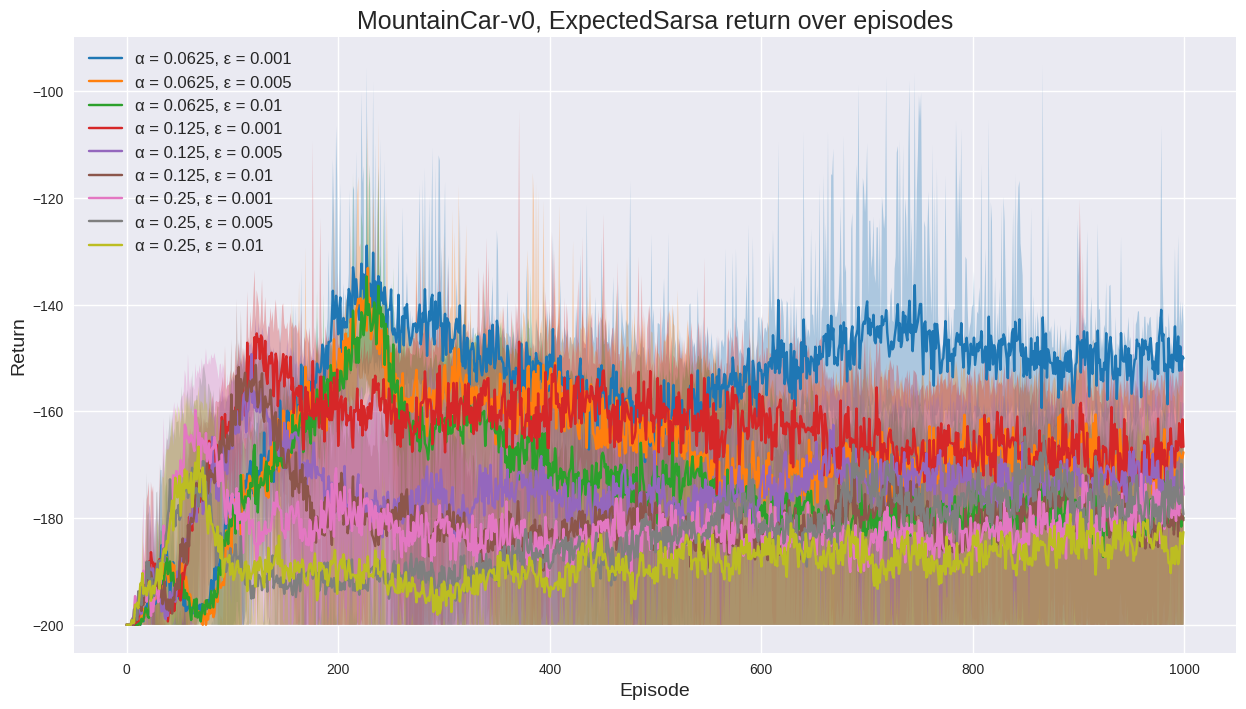

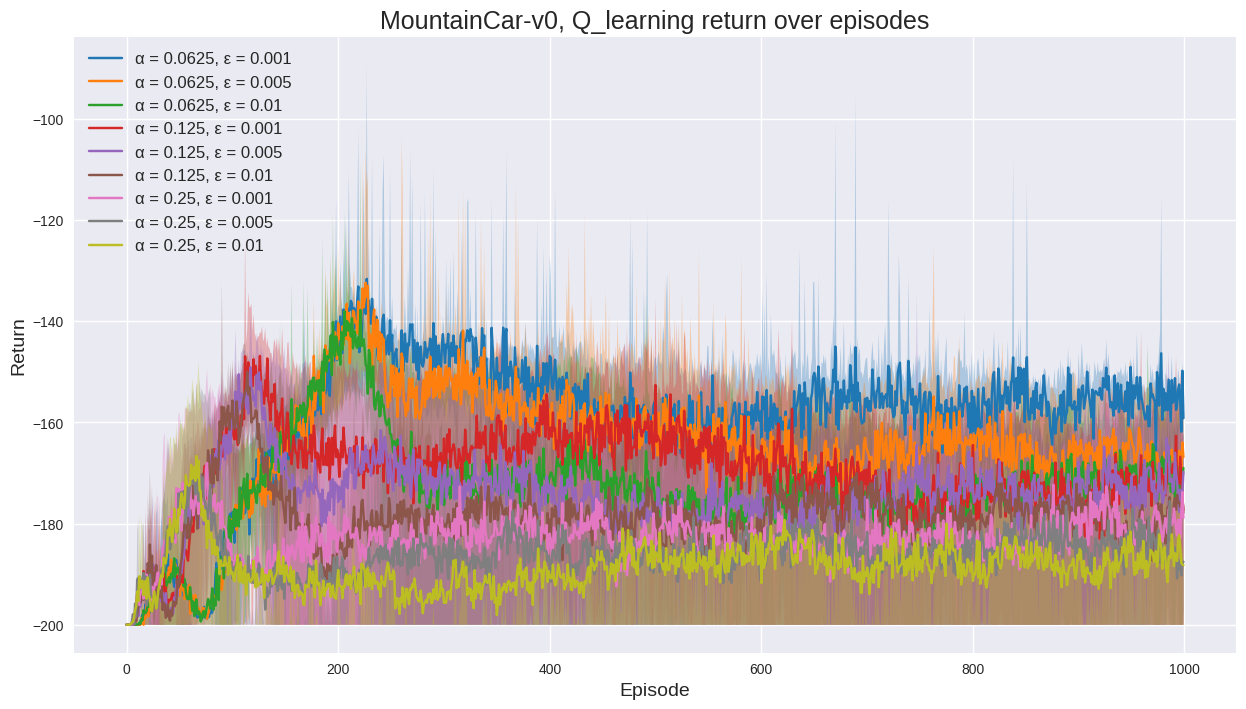

In [ ]:
# Global settings
low = {'CartPole-v1': [-2.4,  -3.8,  -0.27, -3.5], 'MountainCar-v0': [-1.04, -0.04]}
high = {'CartPole-v1': [2.4,  3.7,  0.27, 3.5], 'MountainCar-v0': [0.5,  0.05]}

# Environment and Feature-basis specific settings
env_name = 'MountainCar-v0'

feature_basis_func = identity # cartpole_transform
num_tilings = [2,2]
num_tiles = [20,20]

# no need to touch this part
if feature_basis_func != identity:
    low[env_name], high[env_name] = update_low_high(feature_basis_func, low[env_name], high[env_name])
    print(f'low: {low[env_name]}')
    print(f'high: {high[env_name]}')

tilings = make_tilings(num_tilings, num_tiles, low[env_name], high[env_name])
d = np.dot(num_tilings, num_tiles)
tile_func = lambda s: tile_code(s, tilings, d) # choosing tile coding method

# Settings for run_env_val_based()
algos = [ExpectedSarsa, Q_learning]
alphas = [0.0625, 0.125, 0.25]
epsilons = [0.001, 0.005, 0.01] # choose 3 epsilons
epsilon_dr = 1
gamma = 1
trial_n = 50
ep_n = 1000
verbose = True

####################### SAVE & LOAD SETTINGS ############################
load_pickle_file = 1
# 1 = True: load results from pickle file
# 0 = False: run experiment and get new results
overwrite_pickle_file = 0
# 1 = True: overwrite new results
# 0 = False: doesn't save new results
data_id = env_name[:-2] + "-".join([algo.__name__ for algo in algos]) # Choosing an id for the data
##########################################################################

###################### VALUE-BASED METHOD SECTION #########################
file_path_returns = os.path.join(DIRECTORY_PATH, f"{data_id}-returns.npy")
file_path_algos = os.path.join(DIRECTORY_PATH, f"{data_id}-algos.npy")
file_path_alphas = os.path.join(DIRECTORY_PATH, f"{data_id}-alphas.npy")
file_path_epsilons = os.path.join(DIRECTORY_PATH, f"{data_id}-epsilons.npy")
file_path_trial_n = os.path.join(DIRECTORY_PATH, f"{data_id}-trial_n.npy")
file_path_ep_n = os.path.join(DIRECTORY_PATH, f"{data_id}-ep_n.npy")

if load_pickle_file:
    # load results from pickle file
    print(f"Loading results from {DIRECTORY_PATH}/ {data_id}*.npy")
    returns = np.load(file_path_returns, allow_pickle=True)
    algos = np.load(file_path_algos, allow_pickle=True)
    alphas = np.load(file_path_alphas, allow_pickle=True)
    epsilons = np.load(file_path_epsilons, allow_pickle=True)
    trial_n = np.load(file_path_trial_n, allow_pickle=True)
    ep_n = np.load(file_path_ep_n, allow_pickle=True)
else:
    # run the experiment
    returns = run_env_val_based(env_name, feature_basis_func, tile_func, d, algos, alphas, epsilons, epsilon_dr, gamma, trial_n, ep_n, verbose)
    if overwrite_pickle_file:
        # overwrite file with new results
        print(f"Saving results to {DIRECTORY_PATH}/ {data_id}*.npy")
        np.save(file_path_returns, returns)
        np.save(file_path_algos, algos)
        np.save(file_path_alphas, alphas)
        np.save(file_path_epsilons, epsilons)
        np.save(file_path_trial_n, trial_n)
        np.save(file_path_ep_n, ep_n)

# plotting the results
plot_learning_val_based(env_name, returns)
##########################################################################

## Cart Pole

Loading results from /content/comp-579-a3-data/ CartPole-ExpectedSarsa-Q_learning*.npy


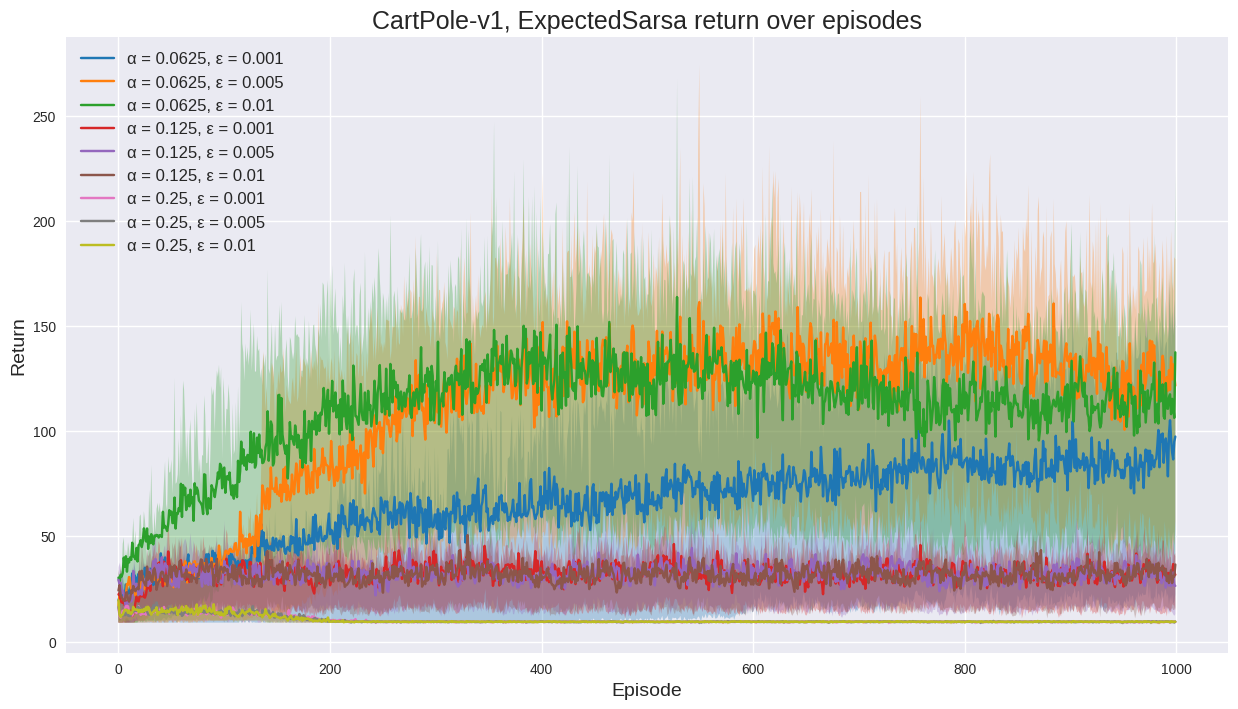

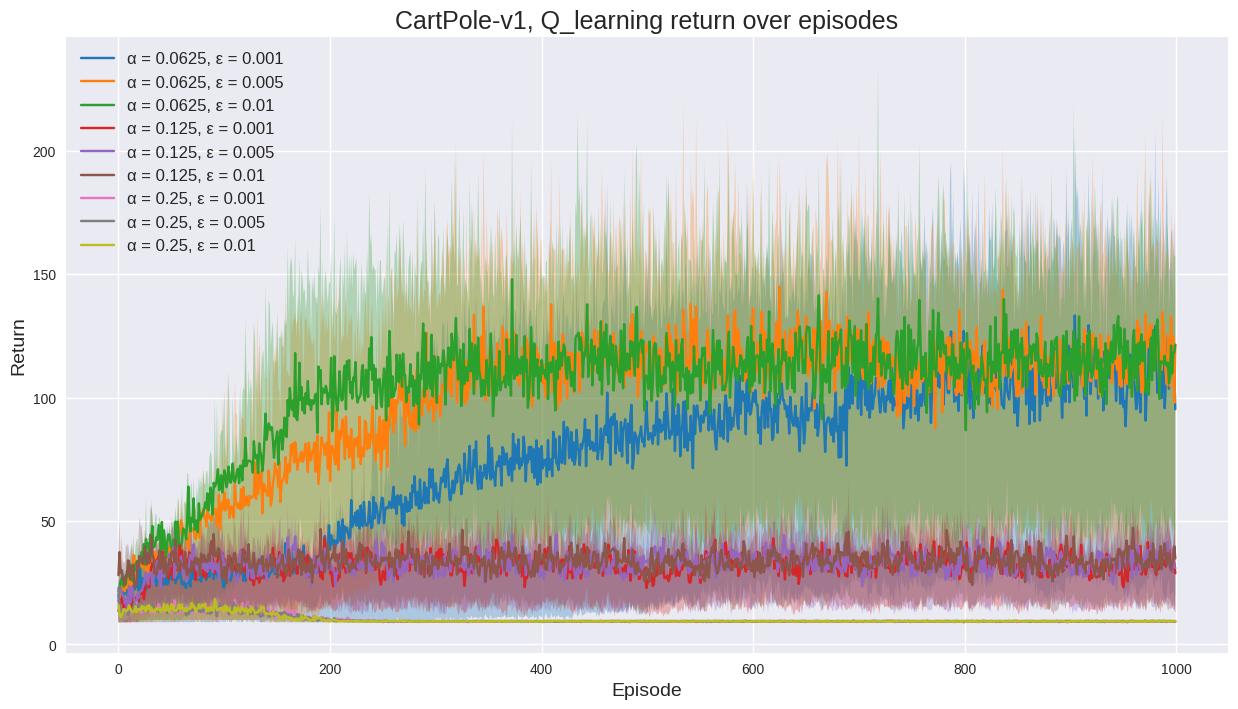

In [ ]:
# Global settings
low = {'CartPole-v1': [-2.4,  -3.8,  -0.27, -3.5], 'MountainCar-v0': [-1.04, -0.04]}
high = {'CartPole-v1': [2.4,  3.7,  0.27, 3.5], 'MountainCar-v0': [0.5,  0.05]}

# Environment and Feature-basis specific settings
env_name = 'CartPole-v1'

feature_basis_func = identity # cartpole_transform
num_tilings = [4,4,4,4]
num_tiles = [20,20,20,20]

# no need to touch this part
if feature_basis_func != identity:
    low[env_name], high[env_name] = update_low_high(feature_basis_func, low[env_name], high[env_name])
    print(f'low: {low[env_name]}')
    print(f'high: {high[env_name]}')

tilings = make_tilings(num_tilings, num_tiles, low[env_name], high[env_name])
d = np.dot(num_tilings, num_tiles)
tile_func = lambda s: tile_code(s, tilings, d) # choosing tile coding method

# Settings for run_env_val_based()
algos = [ExpectedSarsa, Q_learning]
alphas = [0.0625, 0.125, 0.25]
epsilons = [0.001, 0.005, 0.01] # choose 3 epsilons
epsilon_dr = 1
gamma = 1
trial_n = 50
ep_n = 1000
verbose = True

####################### SAVE & LOAD SETTINGS ############################
load_pickle_file = 1
# 1 = True: load results from pickle file
# 0 = False: run experiment and get new results
overwrite_pickle_file = 0
# 1 = True: overwrite new results
# 0 = False: doesn't save new results
data_id = env_name[:-2] + "-".join([algo.__name__ for algo in algos]) # Choosing an id for the data
##########################################################################

###################### VALUE-BASED METHOD SECTION #########################
file_path_returns = os.path.join(DIRECTORY_PATH, f"{data_id}-returns.npy")
file_path_algos = os.path.join(DIRECTORY_PATH, f"{data_id}-algos.npy")
file_path_alphas = os.path.join(DIRECTORY_PATH, f"{data_id}-alphas.npy")
file_path_epsilons = os.path.join(DIRECTORY_PATH, f"{data_id}-epsilons.npy")
file_path_trial_n = os.path.join(DIRECTORY_PATH, f"{data_id}-trial_n.npy")
file_path_ep_n = os.path.join(DIRECTORY_PATH, f"{data_id}-ep_n.npy")

if load_pickle_file:
    # load results from pickle file
    print(f"Loading results from {DIRECTORY_PATH}/ {data_id}*.npy")
    returns = np.load(file_path_returns, allow_pickle=True)
    algos = np.load(file_path_algos, allow_pickle=True)
    alphas = np.load(file_path_alphas, allow_pickle=True)
    epsilons = np.load(file_path_epsilons, allow_pickle=True)
    trial_n = np.load(file_path_trial_n, allow_pickle=True)
    ep_n = np.load(file_path_ep_n, allow_pickle=True)
else:
    # run the experiment
    returns = run_env_val_based(env_name, feature_basis_func, tile_func, d, algos, alphas, epsilons, epsilon_dr, gamma, trial_n, ep_n, verbose)
    if overwrite_pickle_file:
        # overwrite file with new results
        print(f"Saving results to {DIRECTORY_PATH}/ {data_id}*.npy")
        np.save(file_path_returns, returns)
        np.save(file_path_algos, algos)
        np.save(file_path_alphas, alphas)
        np.save(file_path_epsilons, epsilons)
        np.save(file_path_trial_n, trial_n)
        np.save(file_path_ep_n, ep_n)

# plotting the results
plot_learning_val_based(env_name, returns)
##########################################################################

# Policy-based Experiments

## Mountain Car

Loading results from /content/comp-579-a3-data/ MountainCar-ReinforceBaseline*.npy


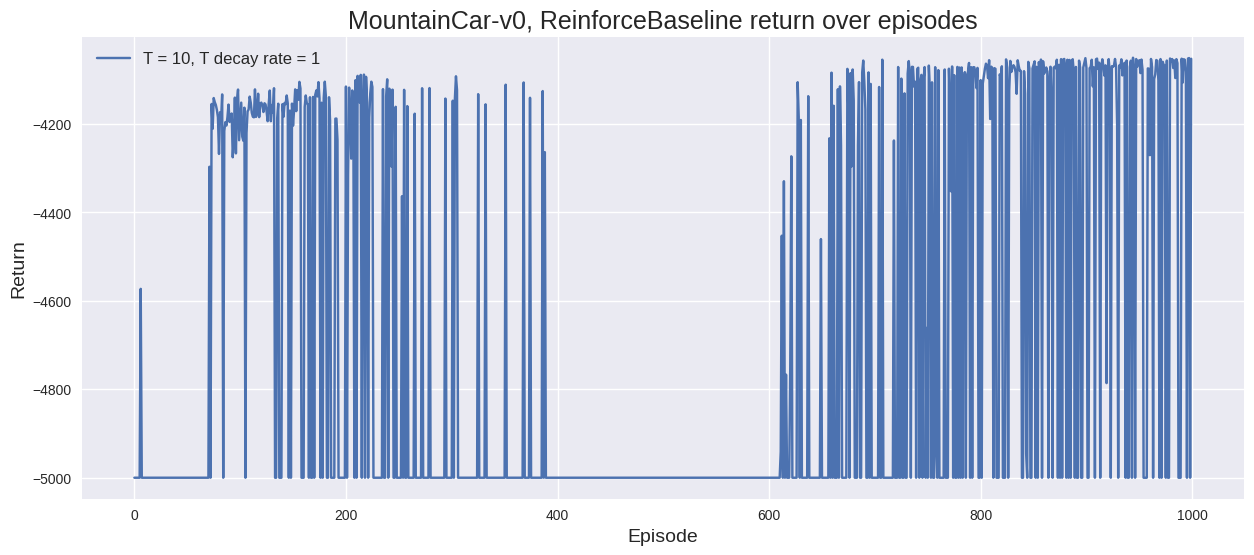

In [ ]:
# Global settings
low = {'CartPole-v1': [-2.4,  -3.8,  -0.27, -3.5], 'MountainCar-v0': [-1.04, -0.04]}
high = {'CartPole-v1': [2.4,  3.7,  0.27, 3.5], 'MountainCar-v0': [0.5,  0.05]}

# Environment and Feature-basis specific settings
env_name = 'MountainCar-v0'

feature_basis_func = identity # cartpole_transform
num_tilings = [2, 2]
num_tiles = [20, 20]

# no need to touch this part
if feature_basis_func != identity:
    low[env_name], high[env_name] = update_low_high(feature_basis_func, low[env_name], high[env_name])
    print(f'low: {low[env_name]}')
    print(f'high: {high[env_name]}')

tilings = make_tilings(num_tilings, num_tiles, low[env_name], high[env_name])
d = np.dot(num_tilings, num_tiles)
tile_func = lambda s: tile_code(s, tilings, d) # choosing tile coding method

# Settings for run_env()
algos = [ReinforceBaseline] #[Reinforce, ActorCritic]
temp = 10
temp_decay_rates = [1]
alpha_theta = 0.01
alpha_w = 0.01
gamma = 1
trial_n = 5
ep_n = 1000
verbose = True
max_steps = 5000

####################### SAVE & LOAD SETTINGS ############################
load_pickle_file = 1
# 1 = True: load results from pickle file
# 0 = False: run experiment and get new results
overwrite_pickle_file = 0
# 1 = True: overwrite new results
# 0 = False: doesn't save new results
data_id = env_name[:-2] + "-".join([algo.__name__ for algo in algos]) # Choosing an id for the data
##########################################################################

###################### POLICY-BASED METHOD SECTION #########################
file_path_returns = os.path.join(DIRECTORY_PATH, f"{data_id}-returns.npy")
file_path_algos = os.path.join(DIRECTORY_PATH, f"{data_id}-algos.npy")
file_path_temp = os.path.join(DIRECTORY_PATH, f"{data_id}-temp.npy")
file_path_temp_decay_rates = os.path.join(DIRECTORY_PATH, f"{data_id}-temp_decay_rates.npy")
file_path_alpha_theta = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_theta.npy")
file_path_alpha_w = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_w.npy")

if load_pickle_file:
    # load results from pickle file
    print(f"Loading results from {DIRECTORY_PATH}/ {data_id}*.npy")
    returns = np.load(file_path_returns, allow_pickle=True)
    algos = np.load(file_path_algos, allow_pickle=True)
    temp = np.load(file_path_temp, allow_pickle=True)
    temp_decay_rates = np.load(file_path_temp_decay_rates, allow_pickle=True)
    alpha_theta = np.load(file_path_alpha_theta, allow_pickle=True)
    alpha_w = np.load(file_path_alpha_w, allow_pickle=True)
else:
    # run the experiment
    returns = run_env_policy_based(env_name, feature_basis_func, tile_func, d, algos, alpha_theta, alpha_w, gamma, temp, temp_decay_rates, trial_n, ep_n, verbose, max_steps)
    if overwrite_pickle_file:
        # overwrite file with new results
        print(f"Saving results to {DIRECTORY_PATH}/ {data_id}*.npy")
        np.save(file_path_returns, returns)
        np.save(file_path_algos, algos)
        np.save(file_path_temp, temp)
        np.save(file_path_temp_decay_rates, temp_decay_rates)
        np.save(file_path_alpha_theta, alpha_theta)
        np.save(file_path_alpha_w, alpha_w)

# plotting the results
plot_learning_policy_based(env_name, returns)
##########################################################################


Loading results from /content/comp-579-a3-data/ MountainCar-ReinforceBaseline*.npy


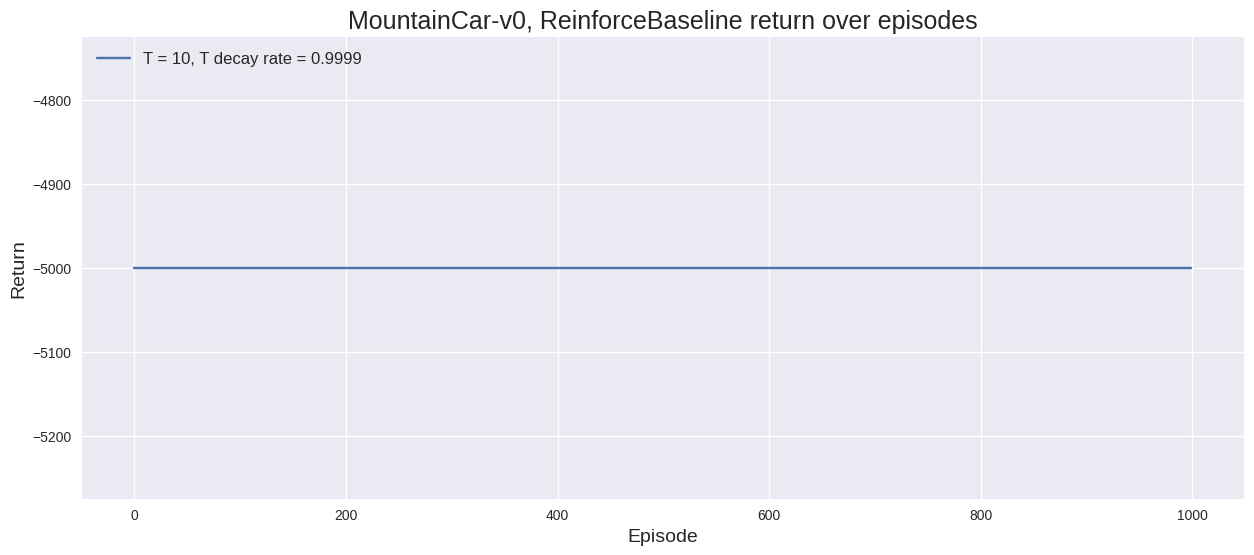

In [ ]:
# Global settings
low = {'CartPole-v1': [-2.4,  -3.8,  -0.27, -3.5], 'MountainCar-v0': [-1.04, -0.04]}
high = {'CartPole-v1': [2.4,  3.7,  0.27, 3.5], 'MountainCar-v0': [0.5,  0.05]}

# Environment and Feature-basis specific settings
env_name = 'MountainCar-v0'

feature_basis_func = identity # cartpole_transform
num_tilings = [2, 2]
num_tiles = [20, 20]

# no need to touch this part
if feature_basis_func != identity:
    low[env_name], high[env_name] = update_low_high(feature_basis_func, low[env_name], high[env_name])
    print(f'low: {low[env_name]}')
    print(f'high: {high[env_name]}')

tilings = make_tilings(num_tilings, num_tiles, low[env_name], high[env_name])
d = np.dot(num_tilings, num_tiles)
tile_func = lambda s: tile_code(s, tilings, d) # choosing tile coding method

# Settings for run_env()
algos = [ReinforceBaseline] #[Reinforce, ActorCritic]
temp = 10
temp_decay_rates = [0.9999]
alpha_theta = 0.01
alpha_w = 0.01
gamma = 1
trial_n = 5
ep_n = 1000
verbose = True
max_steps = 5000

####################### SAVE & LOAD SETTINGS ############################
load_pickle_file = 1
# 1 = True: load results from pickle file
# 0 = False: run experiment and get new results
overwrite_pickle_file = 0
# 1 = True: overwrite new results
# 0 = False: doesn't save new results
data_id = env_name[:-2] + "-".join([algo.__name__ for algo in algos]) # Choosing an id for the data
##########################################################################

###################### POLICY-BASED METHOD SECTION #########################
file_path_returns = os.path.join(DIRECTORY_PATH, f"{data_id}-returns.npy")
file_path_algos = os.path.join(DIRECTORY_PATH, f"{data_id}-algos.npy")
file_path_temp = os.path.join(DIRECTORY_PATH, f"{data_id}-temp.npy")
file_path_temp_decay_rates = os.path.join(DIRECTORY_PATH, f"{data_id}-temp_decay_rates.npy")
file_path_alpha_theta = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_theta.npy")
file_path_alpha_w = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_w.npy")

if load_pickle_file:
    # load results from pickle file
    print(f"Loading results from {DIRECTORY_PATH}/ {data_id}*.npy")
    returns = np.load(file_path_returns, allow_pickle=True)
    algos = np.load(file_path_algos, allow_pickle=True)
    temp = np.load(file_path_temp, allow_pickle=True)
    temp_decay_rates = np.load(file_path_temp_decay_rates, allow_pickle=True)
    alpha_theta = np.load(file_path_alpha_theta, allow_pickle=True)
    alpha_w = np.load(file_path_alpha_w, allow_pickle=True)
else:
    # run the experiment
    returns = run_env_policy_based(env_name, feature_basis_func, tile_func, d, algos, alpha_theta, alpha_w, gamma, temp, temp_decay_rates, trial_n, ep_n, verbose, max_steps)
    if overwrite_pickle_file:
        # overwrite file with new results
        print(f"Saving results to {DIRECTORY_PATH}/ {data_id}*.npy")
        np.save(file_path_returns, returns)
        np.save(file_path_algos, algos)
        np.save(file_path_temp, temp)
        np.save(file_path_temp_decay_rates, temp_decay_rates)
        np.save(file_path_alpha_theta, alpha_theta)
        np.save(file_path_alpha_w, alpha_w)

# plotting the results
plot_learning_policy_based(env_name, returns)
##########################################################################


Streaming output truncated to the last 5000 lines.
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0869) (trial 45 ep 6) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0852) (trial 45 ep 7) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0835) (trial 45 ep 8) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0819) (trial 45 ep 9) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0803) (trial 45 ep 10) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0787) (trial 45 ep 11) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0771) (trial 45 ep 12) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0756) (trial 45 ep 13) truncated -200.0
MountainCar-v0 [2,2] [20,20] ActorCritic (a_th=0.001 a_w=0.01 T=0.0741) (trial 45 ep 14) truncated -200.0

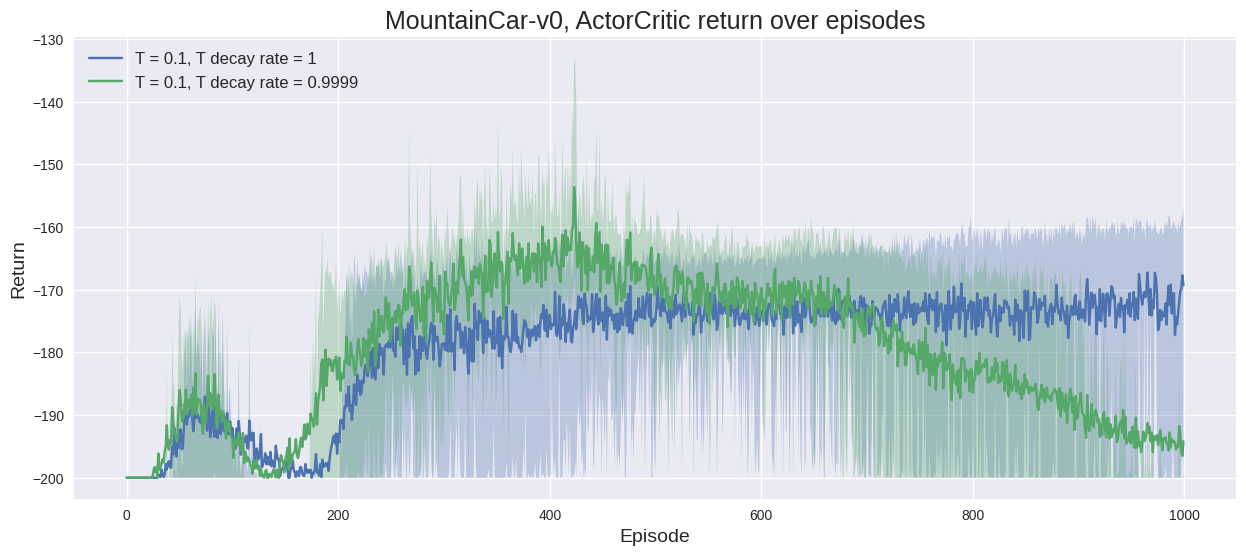

In [ ]:
# Global settings
low = {'CartPole-v1': [-2.4,  -3.8,  -0.27, -3.5], 'MountainCar-v0': [-1.04, -0.04]}
high = {'CartPole-v1': [2.4,  3.7,  0.27, 3.5], 'MountainCar-v0': [0.5,  0.05]}

# Environment and Feature-basis specific settings
env_name = 'MountainCar-v0'

feature_basis_func = identity # cartpole_transform
num_tilings = [2, 2]
num_tiles = [20, 20]

# no need to touch this part
if feature_basis_func != identity:
    low[env_name], high[env_name] = update_low_high(feature_basis_func, low[env_name], high[env_name])
    print(f'low: {low[env_name]}')
    print(f'high: {high[env_name]}')

tilings = make_tilings(num_tilings, num_tiles, low[env_name], high[env_name])
d = np.dot(num_tilings, num_tiles)
tile_func = lambda s: tile_code(s, tilings, d) # choosing tile coding method

# Settings for run_env()
algos = [ActorCritic] #[Reinforce, ActorCritic]
temp = 0.1
temp_decay_rates = [1, 0.9999]
alpha_theta = 0.001
alpha_w = 0.01
gamma = 1
trial_n = 50
ep_n = 1000
verbose = True
max_steps = 200

####################### SAVE & LOAD SETTINGS ############################
load_pickle_file = 0
# 1 = True: load results from pickle file
# 0 = False: run experiment and get new results
overwrite_pickle_file = 1
# 1 = True: overwrite new results
# 0 = False: doesn't save new results
data_id = env_name[:-2] + "-".join([algo.__name__ for algo in algos]) # Choosing an id for the data
##########################################################################

###################### POLICY-BASED METHOD SECTION #########################
file_path_returns = os.path.join(DIRECTORY_PATH, f"{data_id}-returns.npy")
file_path_algos = os.path.join(DIRECTORY_PATH, f"{data_id}-algos.npy")
file_path_temp = os.path.join(DIRECTORY_PATH, f"{data_id}-temp.npy")
file_path_temp_decay_rates = os.path.join(DIRECTORY_PATH, f"{data_id}-temp_decay_rates.npy")
file_path_alpha_theta = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_theta.npy")
file_path_alpha_w = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_w.npy")

if load_pickle_file:
    # load results from pickle file
    print(f"Loading results from {DIRECTORY_PATH}/ {data_id}*.npy")
    returns = np.load(file_path_returns, allow_pickle=True)
    algos = np.load(file_path_algos, allow_pickle=True)
    temp = np.load(file_path_temp, allow_pickle=True)
    temp_decay_rates = np.load(file_path_temp_decay_rates, allow_pickle=True)
    alpha_theta = np.load(file_path_alpha_theta, allow_pickle=True)
    alpha_w = np.load(file_path_alpha_w, allow_pickle=True)
else:
    # run the experiment
    returns = run_env_policy_based(env_name, feature_basis_func, tile_func, d, algos, alpha_theta, alpha_w, gamma, temp, temp_decay_rates, trial_n, ep_n, verbose)
    if overwrite_pickle_file:
        # overwrite file with new results
        print(f"Saving results to {DIRECTORY_PATH}/ {data_id}*.npy")
        np.save(file_path_returns, returns)
        np.save(file_path_algos, algos)
        np.save(file_path_temp, temp)
        np.save(file_path_temp_decay_rates, temp_decay_rates)
        np.save(file_path_alpha_theta, alpha_theta)
        np.save(file_path_alpha_w, alpha_w)

# plotting the results
plot_learning_policy_based(env_name, returns)
##########################################################################

## Cart Pole

Streaming output truncated to the last 5000 lines.
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.9796) (trial 45 ep 6) terminated 21.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.9763) (trial 45 ep 7) terminated 34.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.975) (trial 45 ep 8) terminated 13.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.9731) (trial 45 ep 9) terminated 20.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.9715) (trial 45 ep 10) terminated 16.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.9675) (trial 45 ep 11) terminated 41.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.9666) (trial 45 ep 12) terminated 10.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ReinforceBaseline (a_th=0.0001 a_w=0.0001 T=0.9648) (trial 45 ep 13) te

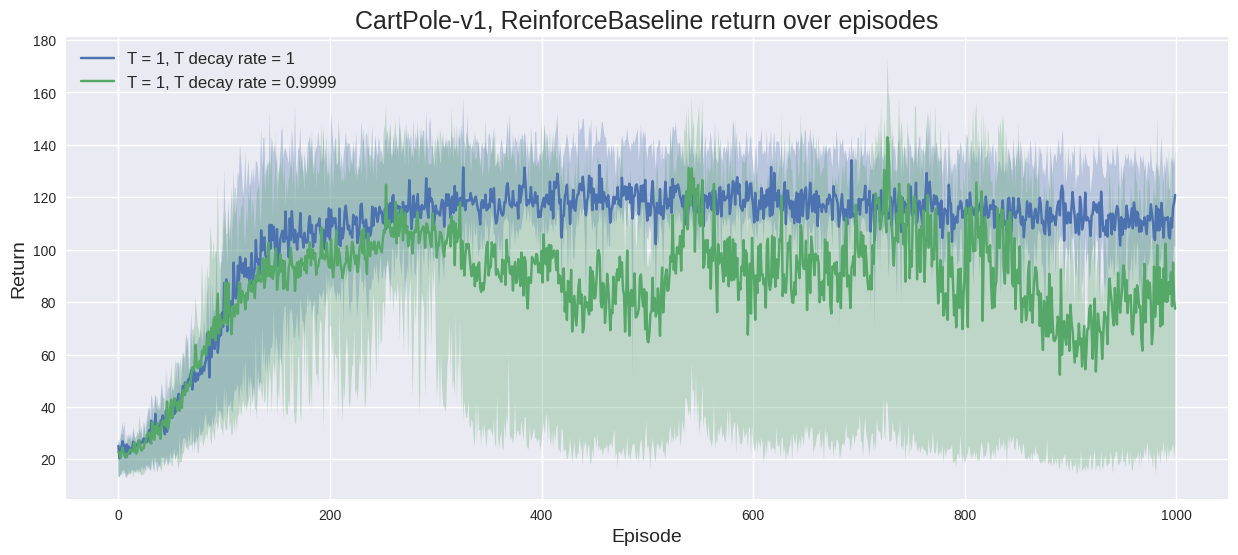

In [ ]:
# Global settings
low = {'CartPole-v1': [-2.4,  -3.8,  -0.27, -3.5], 'MountainCar-v0': [-1.04, -0.04]}
high = {'CartPole-v1': [2.4,  3.7,  0.27, 3.5], 'MountainCar-v0': [0.5,  0.05]}

# Environment and Feature-basis specific settings
env_name = 'CartPole-v1'

feature_basis_func = identity # cartpole_transform
num_tilings = [4,4,4,4]
num_tiles = [20,20,20,20]

# no need to touch this part
if feature_basis_func != identity:
    low[env_name], high[env_name] = update_low_high(feature_basis_func, low[env_name], high[env_name])
    print(f'low: {low[env_name]}')
    print(f'high: {high[env_name]}')

tilings = make_tilings(num_tilings, num_tiles, low[env_name], high[env_name])
d = np.dot(num_tilings, num_tiles)
tile_func = lambda s: tile_code(s, tilings, d) # choosing tile coding method

# Settings for run_env_val_based()
algos = [ReinforceBaseline]
temp = 1
temp_decay_rates = [1, 0.9999]
alpha_theta = 0.0001
alpha_w = 0.0001
gamma = 1
trial_n = 50
ep_n = 1000
verbose = True

####################### SAVE & LOAD SETTINGS ############################
load_pickle_file = 0
# 1 = True: load results from pickle file
# 0 = False: run experiment and get new results
overwrite_pickle_file = 1
# 1 = True: overwrite new results
# 0 = False: doesn't save new results
data_id = env_name[:-2] + "-".join([algo.__name__ for algo in algos]) # Choosing an id for the data
##########################################################################

###################### POLICY-BASED METHOD SECTION #########################
file_path_returns = os.path.join(DIRECTORY_PATH, f"{data_id}-returns.npy")
file_path_algos = os.path.join(DIRECTORY_PATH, f"{data_id}-algos.npy")
file_path_temp = os.path.join(DIRECTORY_PATH, f"{data_id}-temp.npy")
file_path_temp_decay_rates = os.path.join(DIRECTORY_PATH, f"{data_id}-temp_decay_rates.npy")
file_path_alpha_theta = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_theta.npy")
file_path_alpha_w = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_w.npy")

if load_pickle_file:
    # load results from pickle file
    print(f"Loading results from {DIRECTORY_PATH}/ {data_id}*.npy")
    returns = np.load(file_path_returns, allow_pickle=True)
    algos = np.load(file_path_algos, allow_pickle=True)
    temp = np.load(file_path_temp, allow_pickle=True)
    temp_decay_rates = np.load(file_path_temp_decay_rates, allow_pickle=True)
    alpha_theta = np.load(file_path_alpha_theta, allow_pickle=True)
    alpha_w = np.load(file_path_alpha_w, allow_pickle=True)
else:
    # run the experiment
    returns = run_env_policy_based(env_name, feature_basis_func, tile_func, d, algos, alpha_theta, alpha_w, gamma, temp, temp_decay_rates, trial_n, ep_n, verbose)
    if overwrite_pickle_file:
        # overwrite file with new results
        print(f"Saving results to {DIRECTORY_PATH}/ {data_id}*.npy")
        np.save(file_path_returns, returns)
        np.save(file_path_algos, algos)
        np.save(file_path_temp, temp)
        np.save(file_path_temp_decay_rates, temp_decay_rates)
        np.save(file_path_alpha_theta, alpha_theta)
        np.save(file_path_alpha_w, alpha_w)

# plotting the results
plot_learning_policy_based(env_name, returns)
##########################################################################

Streaming output truncated to the last 5000 lines.
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 6) terminated 11.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 7) terminated 10.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 8) terminated 9.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 9) terminated 10.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 10) terminated 9.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 11) terminated 11.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 12) terminated 11.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 45 ep 13) terminated 9.0
CartPole-v1 [4,4,4,4] [20,20,20,20] ActorCritic (a_th=0.1 a_w=0.1 T=0.0099) (trial 4

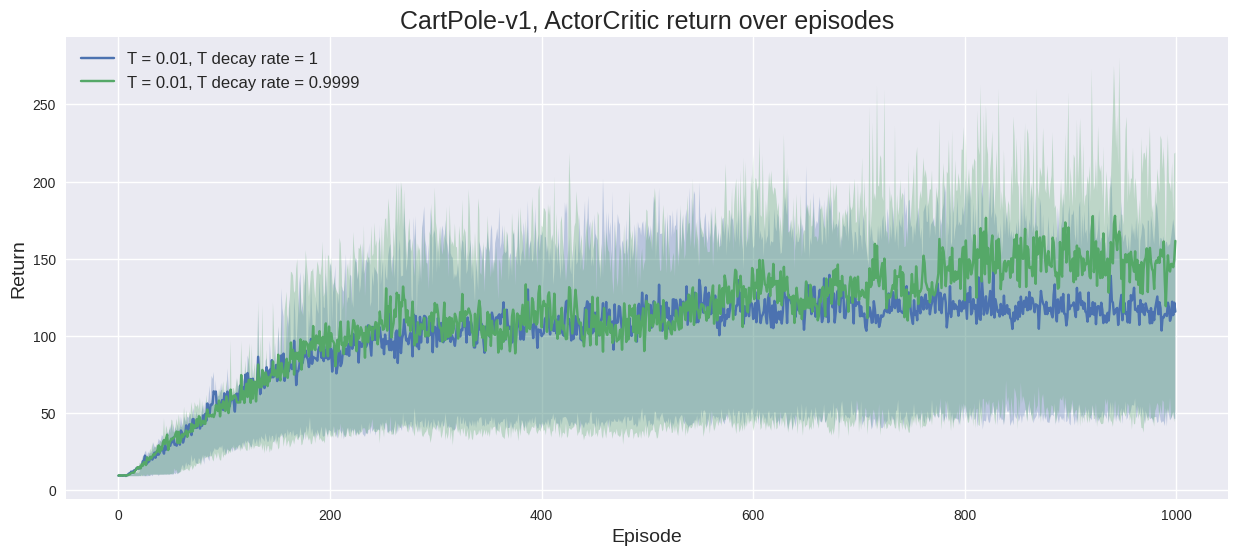

In [ ]:
# Global settings
low = {'CartPole-v1': [-2.4,  -3.8,  -0.27, -3.5], 'MountainCar-v0': [-1.04, -0.04]}
high = {'CartPole-v1': [2.4,  3.7,  0.27, 3.5], 'MountainCar-v0': [0.5,  0.05]}

# Environment and Feature-basis specific settings
env_name = 'CartPole-v1'

feature_basis_func = identity # cartpole_transform
num_tilings = [4,4,4,4]
num_tiles = [20,20,20,20]

# no need to touch this part
if feature_basis_func != identity:
    low[env_name], high[env_name] = update_low_high(feature_basis_func, low[env_name], high[env_name])
    print(f'low: {low[env_name]}')
    print(f'high: {high[env_name]}')

tilings = make_tilings(num_tilings, num_tiles, low[env_name], high[env_name])
d = np.dot(num_tilings, num_tiles)
tile_func = lambda s: tile_code(s, tilings, d) # choosing tile coding method

# Settings for run_env_val_based()
algos = [ActorCritic]
temp = 0.01
temp_decay_rates = [1, 0.9999]
alpha_theta = 0.1
alpha_w = 0.1
gamma = 1
trial_n = 50
ep_n = 1000
verbose = True

####################### SAVE & LOAD SETTINGS ############################
load_pickle_file = 0
# 1 = True: load results from pickle file
# 0 = False: run experiment and get new results
overwrite_pickle_file = 1
# 1 = True: overwrite new results
# 0 = False: doesn't save new results
data_id = env_name[:-2] + "-".join([algo.__name__ for algo in algos]) # Choosing an id for the data
##########################################################################

###################### POLICY-BASED METHOD SECTION #########################
file_path_returns = os.path.join(DIRECTORY_PATH, f"{data_id}-returns.npy")
file_path_algos = os.path.join(DIRECTORY_PATH, f"{data_id}-algos.npy")
file_path_temp = os.path.join(DIRECTORY_PATH, f"{data_id}-temp.npy")
file_path_temp_decay_rates = os.path.join(DIRECTORY_PATH, f"{data_id}-temp_decay_rates.npy")
file_path_alpha_theta = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_theta.npy")
file_path_alpha_w = os.path.join(DIRECTORY_PATH, f"{data_id}-alpha_w.npy")

if load_pickle_file:
    # load results from pickle file
    print(f"Loading results from {DIRECTORY_PATH}/ {data_id}*.npy")
    returns = np.load(file_path_returns, allow_pickle=True)
    algos = np.load(file_path_algos, allow_pickle=True)
    temp = np.load(file_path_temp, allow_pickle=True)
    temp_decay_rates = np.load(file_path_temp_decay_rates, allow_pickle=True)
    alpha_theta = np.load(file_path_alpha_theta, allow_pickle=True)
    alpha_w = np.load(file_path_alpha_w, allow_pickle=True)
else:
    # run the experiment
    returns = run_env_policy_based(env_name, feature_basis_func, tile_func, d, algos, alpha_theta, alpha_w, gamma, temp, temp_decay_rates, trial_n, ep_n, verbose)
    if overwrite_pickle_file:
        # overwrite file with new results
        print(f"Saving results to {DIRECTORY_PATH}/ {data_id}*.npy")
        np.save(file_path_returns, returns)
        np.save(file_path_algos, algos)
        np.save(file_path_temp, temp)
        np.save(file_path_temp_decay_rates, temp_decay_rates)
        np.save(file_path_alpha_theta, alpha_theta)
        np.save(file_path_alpha_w, alpha_w)

# plotting the results
plot_learning_policy_based(env_name, returns)
##########################################################################